In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [12]:
data_dir = Path('../data')
df = pd.concat(
	pd.read_parquet(parquet_file)
	for parquet_file in data_dir.glob('*.parquet')
)
df.shape

(2400, 9)

In [13]:
df['asking_price'] = df.asking_price / df.suite_area

In [14]:
df = df.dropna(
	subset=['latitude', 'longitude']
)
df.shape

(1357, 9)

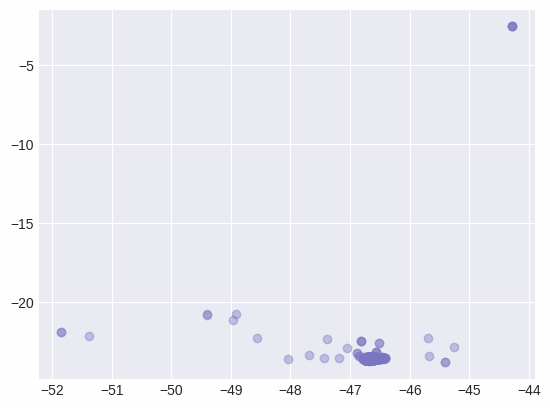

In [15]:
plt.scatter(df.longitude, df.latitude, alpha=0.4);

In [36]:
db = DBSCAN(eps=0.1, min_samples=10).fit(df[['longitude', 'latitude']])

df['cluster'] = db.labels_

n_clusters_ = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)
n_noise_ = list(df['cluster']).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

Estimated number of clusters: 2
Estimated number of noise points: 35


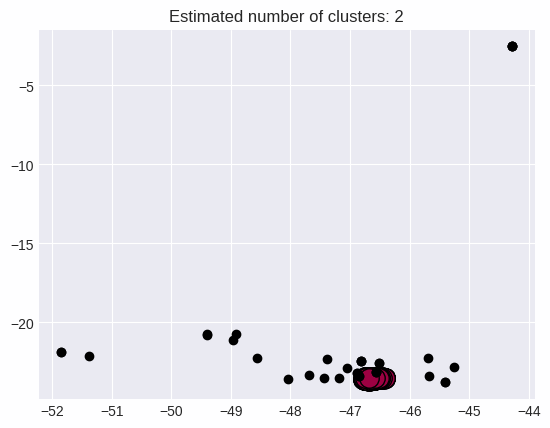

In [37]:
unique_labels = set(df['cluster'])
core_samples_mask = np.zeros_like(df['cluster'], dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
	if k == -1:
		# Black used for noise.
		col = [0, 0, 0, 1]

	class_member_mask = df['cluster'] == k

	xy = df[class_member_mask & core_samples_mask]
	plt.plot(
		xy['longitude'],
		xy['latitude'],
		"o",
		markerfacecolor=tuple(col),
		markeredgecolor="k",
		markersize=14,
	)

	xy = df[class_member_mask & ~core_samples_mask]
	plt.plot(
		xy['longitude'],
		xy['latitude'],
		"o",
		markerfacecolor=tuple(col),
		markeredgecolor="k",
		markersize=6,
	)

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

<Axes: xlabel='cluster', ylabel='asking_price'>

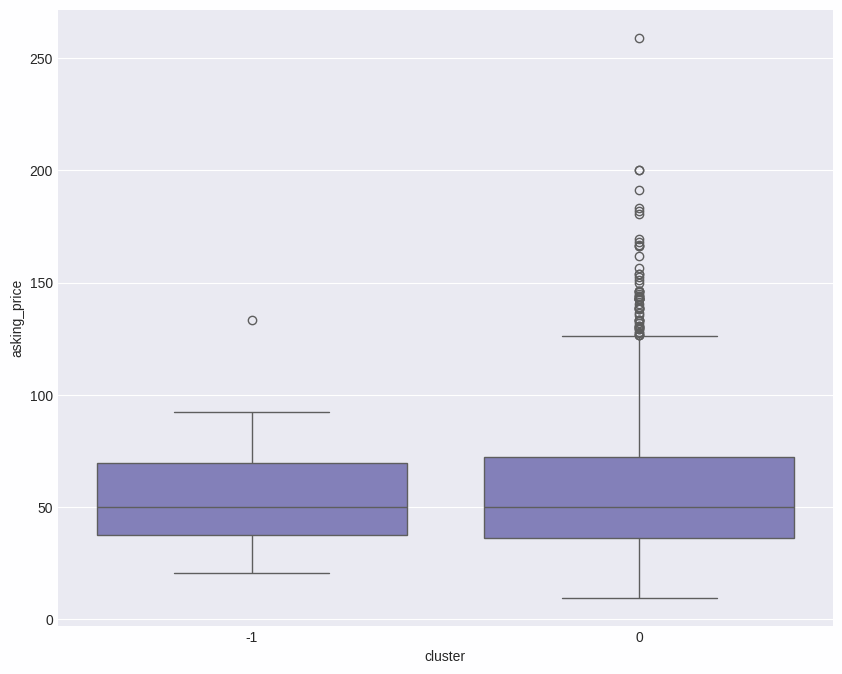

In [38]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='cluster', y='asking_price', data=df)

In [39]:
df[df.cluster == 0].describe()

,suite_area,condominium,tax,asking_price,latitude,longitude,cluster
count,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000,1322.000000,1322.0
mean,52.180030,536.024962,85.674735,58.443691,-23.561522,-46.633567,0.0
std,31.581877,452.290981,153.998855,32.090866,0.042973,0.063802,0.0
min,12.000000,0.000000,0.000000,9.444444,-23.688078,-46.784212,0.0
25%,32.000000,269.250000,0.000000,36.000000,-23.593103,-46.674376,0.0
50%,45.000000,471.000000,43.500000,49.760417,-23.556564,-46.639969,0.0
75%,62.000000,707.750000,109.750000,72.166667,-23.535711,-46.606290,0.0
max,342.000000,4800.000000,2250.000000,259.259259,-23.444893,-46.416988,0.0


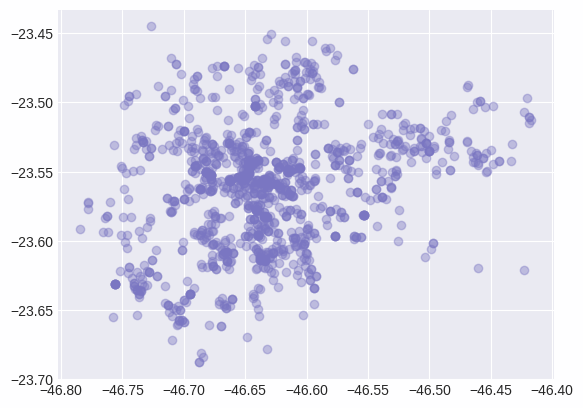

In [40]:
plt.scatter(df[df.cluster == 0].longitude, df[df.cluster == 0].latitude, alpha=0.4);

In [42]:
df[df.cluster == 0].drop('cluster', axis=1).to_parquet('../data/main_cluster.parquet')